In [1]:
import corner
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tftables
import time

import data_loader
import model_short as model
import toy_data_loader

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
np.set_printoptions(suppress=True, precision=3)

In [3]:
class hps:
    pass
hps.n_levels = 3 # number of splits
hps.depth = 3 # number of layers in revnet
hps.width = 16 # channels in revnet layers
hps.polyak_epochs = 1
hps.beta1 = .9 # learning rate annealing factor
hps.weight_decay = 1 # learning rate annealing factor
hps.lr = .001 # base learning rate
hps.n_data = 4000 # number of input spectra
hps.batch_size = 25 # number of spectra in a batch
hps.n_batches = int(hps.n_data / hps.batch_size)
hps.n_bins = 2**13

In [4]:
sess = tf.InteractiveSession()

In [5]:
# select real or toy data by uncommenting the appropriate line
# real data must have n_data=8000, n_bins=40000
#input_stream, initialize_input_stream, data_init = data_loader.create_data_loader(
input_stream, initialize_input_stream, data_init = toy_data_loader.create_data_loader(
    sess, hps.batch_size, hps.n_data, hps.n_bins
)

/home/tey/glow/toy_data_loader.py:9: RuntimeWarning: overflow encountered in exp
  return 2 * h * c**2 / wavelength**5 * 1 / (np.exp(h * c / (wavelength * k * T)) - 1)
W0204 19:04:51.783490 140599685293824 deprecation.py:323] From /home/tey/glow/toy_data_loader.py:35: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


(25, 8192, 1)


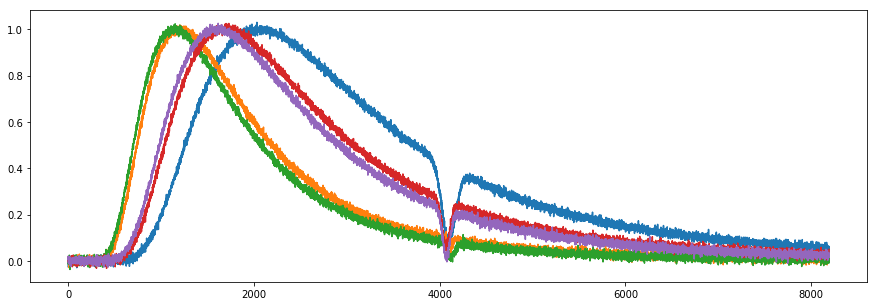

In [6]:
print(data_init.shape)
plt.figure(figsize=(15, 5))
for spectrum in data_init[:5]:
    plt.plot(spectrum)

In [7]:
with tf.device("/device:GPU:0"):
    m = model.model(sess, hps, input_stream, data_init)

W0204 19:04:52.458009 140599685293824 deprecation.py:506] From /home/tey/env/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0204 19:04:52.514395 140599685293824 deprecation_wrapper.py:119] From /home/tey/glow/tfops_short.py:102: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



Tensor("input/latent_rep:0", shape=(?, 512, 4), dtype=float32, device=/device:GPU:0)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512


W0204 19:04:55.877393 140599685293824 deprecation.py:323] From /home/tey/env/lib/python3.5/site-packages/tensorflow/python/training/moving_averages.py:433: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512


W0204 19:04:58.300503 140599685293824 deprecation_wrapper.py:119] From /home/tey/glow/model_short.py:156: The name tf.matrix_inverse is deprecated. Please use tf.linalg.inv instead.

W0204 19:04:58.418809 140599685293824 deprecation_wrapper.py:119] From /home/tey/glow/model_short.py:183: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048


In [8]:
%%time
m.train(.001)

CPU times: user 2.25 s, sys: 252 ms, total: 2.5 s
Wall time: 2.5 s


array([185.307], dtype=float32)

In [19]:
n_processed = 0

hps.epochs = 5
hps.epochs_warmup = 5
hps.print_freq = 10

for epoch in range(1, hps.epochs + 1):
    train_results = []
    initialize_input_stream()
    epoch_start_time = time.time()
    for iteration in range(hps.n_batches):
        lr = hps.lr * min(1., n_processed / (hps.batch_size * hps.n_batches * hps.epochs_warmup))
        start_time = time.time()
        train_results += [m.train(lr)]
        n_processed += hps.batch_size
        #if epoch == 1 and iteration % hps.print_freq == 0:
            #print(epoch, iteration, np.round(time.time() - start_time, 3), train_results[-1][0])
    print(epoch, np.round(time.time() - epoch_start_time, 3), np.round(np.mean(train_results, axis=0), 3))

1 5.518 [86.181]
2 3.881 [16.234]
3 4.053 [1.728]
4 4.03 [0.396]
5 3.951 [-0.498]


In [8]:
i = np.random.randint(0, hps.batch_size)
spectrum = data_init[i:i+1, :, :]
print(i)

19


In [9]:
latent_rep = m.encode(spectrum)
reconstruction = m.decode(latent_rep)

In [10]:
print(latent_rep.mean(), latent_rep.std())

-12.826986 17.233212


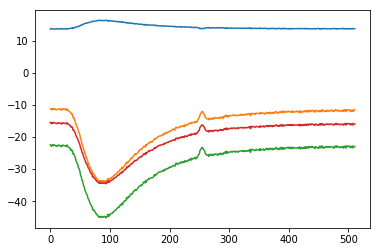

In [11]:
for channel in range(latent_rep.shape[-1]):
    plt.plot(latent_rep[0, :, channel])

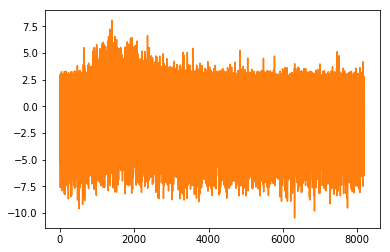

In [12]:
plt.plot(np.squeeze(spectrum))
plt.plot(np.squeeze(reconstruction))

(3276.8, 4915.2)

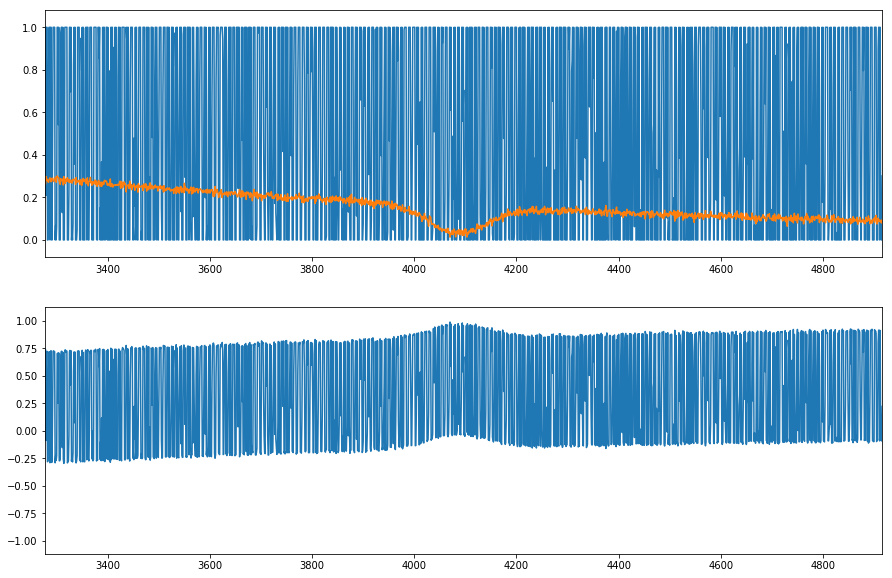

In [13]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(np.squeeze(np.clip(reconstruction, 0, 1)))
plt.plot(np.squeeze(spectrum))
#plt.xlim(12000, 14000)
plt.xlim(hps.n_bins*.4, hps.n_bins*.6)

plt.subplot(2, 1, 2)
plt.plot(np.squeeze(np.clip(reconstruction, 0, 1)) - np.squeeze(spectrum))
#plt.xlim(12000, 14000)
plt.xlim(hps.n_bins*.4, hps.n_bins*.6)

In [14]:
# Make a corner plot with 4 components of the latent representation
latent_reps = np.empty([0, 512])
initialize_input_stream()
for _ in range(hps.n_batches):
    data = sess.run(input_stream)
    latent_rep = m.encode(data)
    latent_reps = np.append(latent_reps, latent_rep[:, :, 0], axis=0) # select all channels of one component

In [15]:
print(latent_reps.shape)
print(latent_reps[:, :8].mean(axis=0))
print(latent_reps[:, :8].std(axis=0))

(4000, 512)
[13.783 13.782 13.783 13.784 13.783 13.782 13.782 13.781]
[0.052 0.053 0.052 0.052 0.052 0.052 0.052 0.051]


In [16]:
# (4000, 4) [ 0.519  2.818 -0.645  0.656] [0.904 0.875 1.292 0.917]
# (4000, 4) [ 0.874  1.28  -0.015  0.373] [0.779 0.703 1.308 0.931]
# (4000, 4) [ 0.085  1.306 -0.169  0.428] [1.076 0.701 1.141 0.915]
# (4000, 4) [-0.711  0.53   0.036 -0.036] [0.965 0.793 1.073 1.109]
# (4000, 4) [-0.627  0.594  0.042 -0.146] [0.893 0.872 1.177 1.143]

W0204 19:09:47.241083 140599685293824 corner.py:542] Too few points to create valid contours


KeyboardInterrupt: 

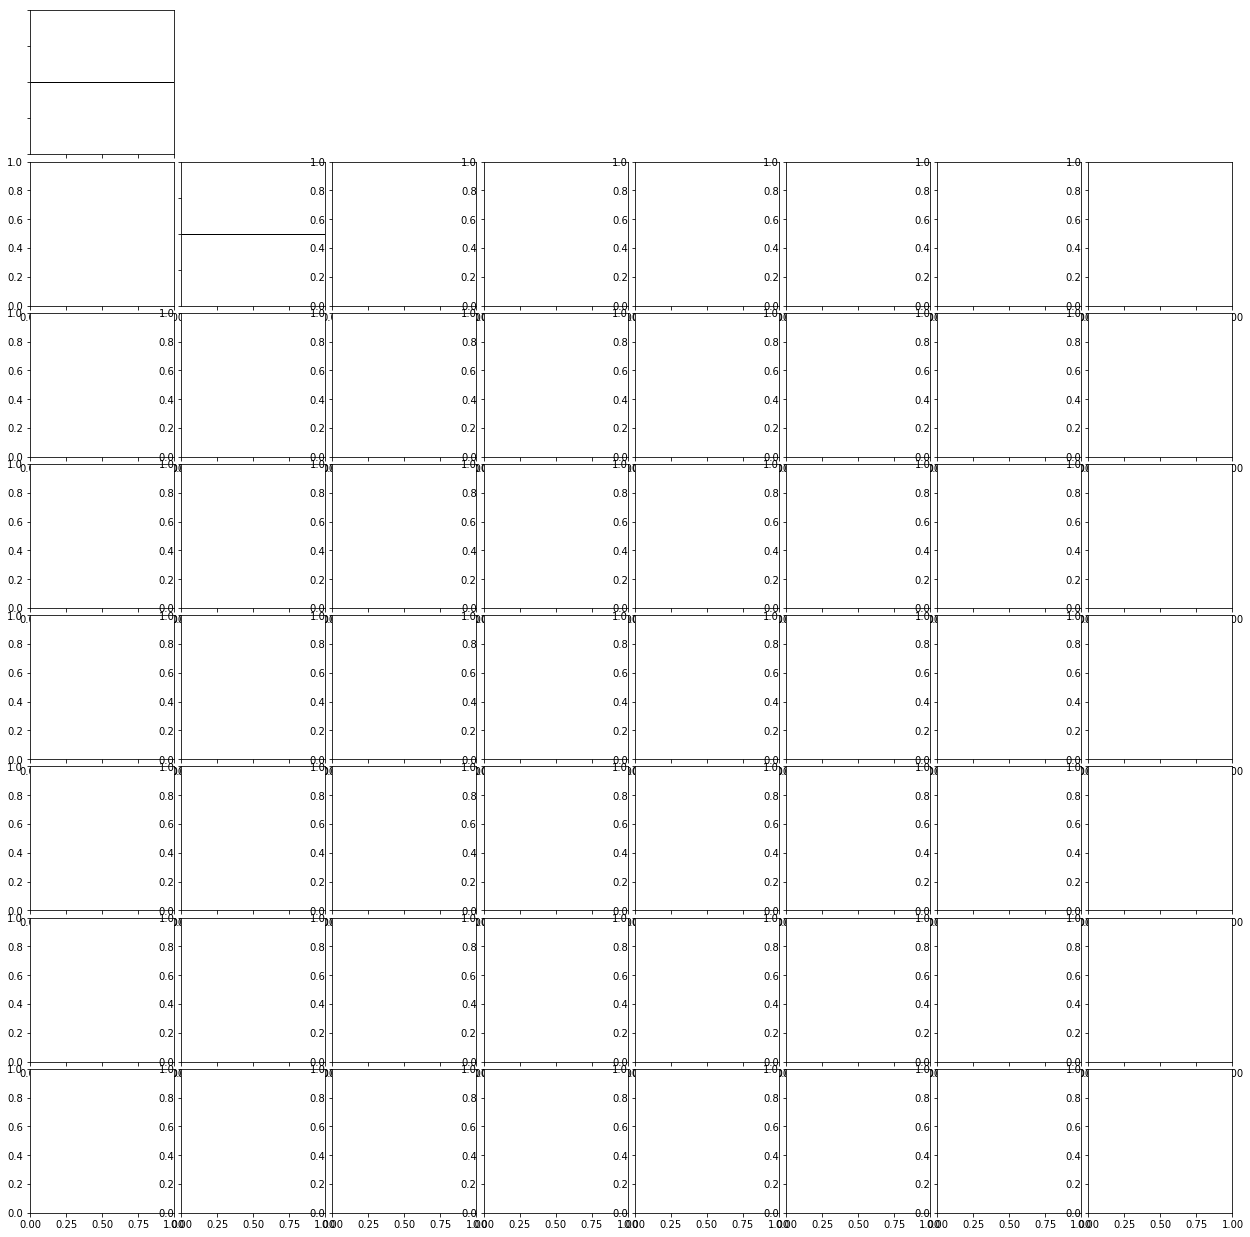

In [18]:
components = 8
figure = corner.corner(latent_reps[:, :components], range=components*[(-4, 4)])

axes = np.array(figure.axes).reshape((components, components))
for yi in range(components):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(0, color="g")
        ax.axhline(0, color="g")